# Parameter Sensitivity Analysis

This notebook explores how ERH behavior changes with different parameters:
- Judgment system parameters (bias_strength, noise_scale)
- Action space parameters (complexity_dist, moral_ambiguity_factor)
- Ethical prime selection criteria (importance_quantile, strategy)

We identify which parameters most strongly affect whether ERH is satisfied.


In [1]:
import sys
import os
from pathlib import Path

# Robust path setup
def setup_paths():
    current_dir = Path(os.getcwd())
    if current_dir.name == 'notebooks':
        simulation_dir = str(current_dir.parent)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    elif current_dir.name == 'simulation':
        simulation_dir = str(current_dir)
        if simulation_dir not in sys.path:
            sys.path.insert(0, simulation_dir)
        return simulation_dir
    for parent in current_dir.parents:
        if parent.name == 'simulation':
            simulation_dir = str(parent)
            if simulation_dir not in sys.path:
                sys.path.insert(0, simulation_dir)
            return simulation_dir
    for path in ['..', '../simulation', 'simulation']:
        abs_path = os.path.abspath(path)
        if abs_path not in sys.path:
            sys.path.insert(0, abs_path)
    return None

setup_paths()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
try:
    import ipywidgets as widgets
    from IPython.display import display
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False

from core.action_space import generate_world
from core.judgement_system import BiasedJudge, NoisyJudge, ConservativeJudge, RadicalJudge, evaluate_judgement
from core.ethical_primes import select_ethical_primes, compute_Pi_and_error, analyze_error_growth
from visualization.plots import setup_paper_style

setup_paper_style()
np.random.seed(42)


## 1D Parameter Sweeps

Sweep individual parameters to understand their impact on ERH satisfaction.


Running 1D parameter sweeps...


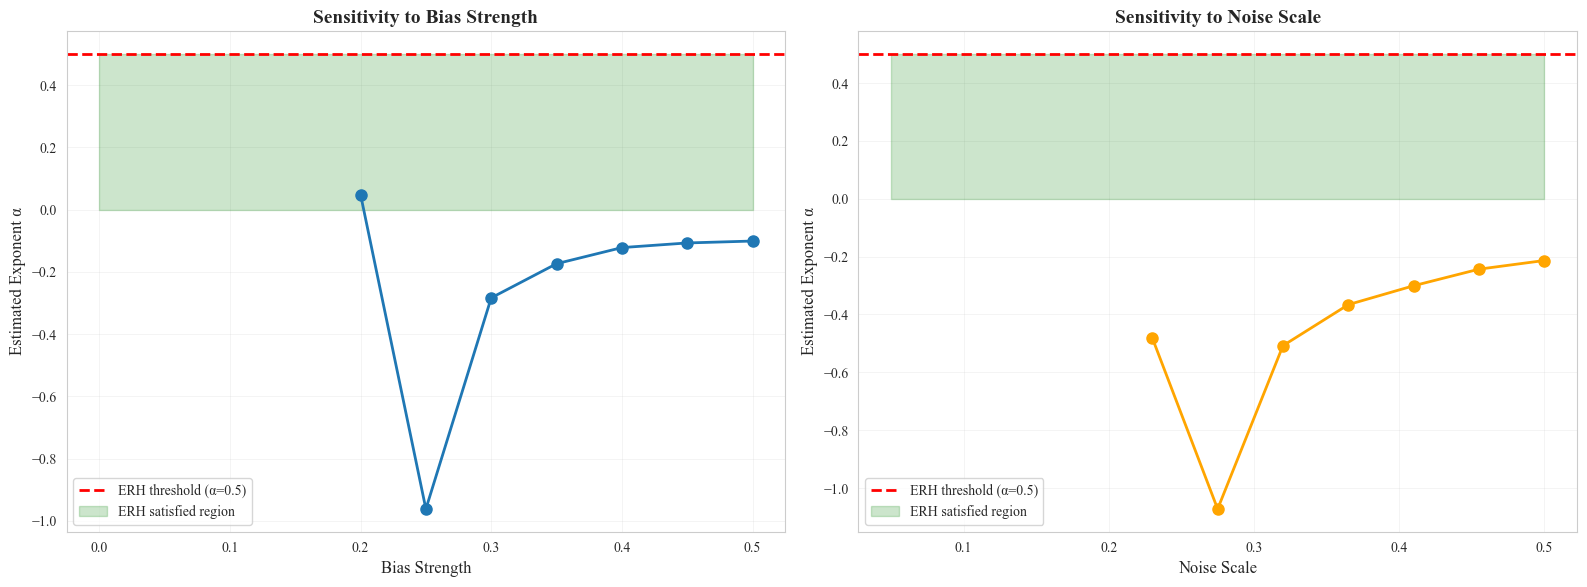

1D parameter sweeps complete!


In [2]:
# Configuration
num_actions = 1000
tau = 0.3
X_max = 100
n_points = 11

print("Running 1D parameter sweeps...")
print("=" * 60)

# Sweep bias_strength
bias_strengths = np.linspace(0, 0.5, n_points)
exponents_bias = []
erh_satisfied_bias = []

for bias in bias_strengths:
    actions = generate_world(num_actions=num_actions, random_seed=42)
    judge = BiasedJudge(bias_strength=bias, noise_scale=0.1)
    evaluate_judgement(actions, judge, tau=tau)
    primes = select_ethical_primes(actions)
    
    if len(primes) > 10:
        Pi_x, B_x, E_x, x_vals = compute_Pi_and_error(primes, X_max=X_max)
        analysis = analyze_error_growth(E_x, x_vals)
        exponents_bias.append(analysis['estimated_exponent'])
        erh_satisfied_bias.append(analysis.get('erh_satisfied', False))
    else:
        exponents_bias.append(np.nan)
        erh_satisfied_bias.append(False)

# Sweep noise_scale
noise_scales = np.linspace(0.05, 0.5, n_points)
exponents_noise = []

for noise in noise_scales:
    actions = generate_world(num_actions=num_actions, random_seed=42)
    judge = NoisyJudge(noise_scale=noise)
    evaluate_judgement(actions, judge, tau=tau)
    primes = select_ethical_primes(actions)
    
    if len(primes) > 10:
        Pi_x, B_x, E_x, x_vals = compute_Pi_and_error(primes, X_max=X_max)
        analysis = analyze_error_growth(E_x, x_vals)
        exponents_noise.append(analysis['estimated_exponent'])
    else:
        exponents_noise.append(np.nan)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bias strength
ax1 = axes[0]
ax1.plot(bias_strengths, exponents_bias, 'o-', linewidth=2, markersize=8)
ax1.axhline(y=0.5, color='r', linestyle='--', linewidth=2, label='ERH threshold (α=0.5)')
ax1.fill_between(bias_strengths, 0, 0.5, alpha=0.2, color='green', label='ERH satisfied region')
ax1.set_xlabel('Bias Strength', fontsize=12)
ax1.set_ylabel('Estimated Exponent α', fontsize=12)
ax1.set_title('Sensitivity to Bias Strength', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Noise scale
ax2 = axes[1]
ax2.plot(noise_scales, exponents_noise, 'o-', linewidth=2, markersize=8, color='orange')
ax2.axhline(y=0.5, color='r', linestyle='--', linewidth=2, label='ERH threshold (α=0.5)')
ax2.fill_between(noise_scales, 0, 0.5, alpha=0.2, color='green', label='ERH satisfied region')
ax2.set_xlabel('Noise Scale', fontsize=12)
ax2.set_ylabel('Estimated Exponent α', fontsize=12)
ax2.set_title('Sensitivity to Noise Scale', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/04_1d_sensitivity.pdf', dpi=300)
plt.show()

print("1D parameter sweeps complete!")


## 2D Parameter Space Exploration

Explore the joint effect of two parameters using heatmaps.


Running 2D parameter sweep (this may take a moment)...


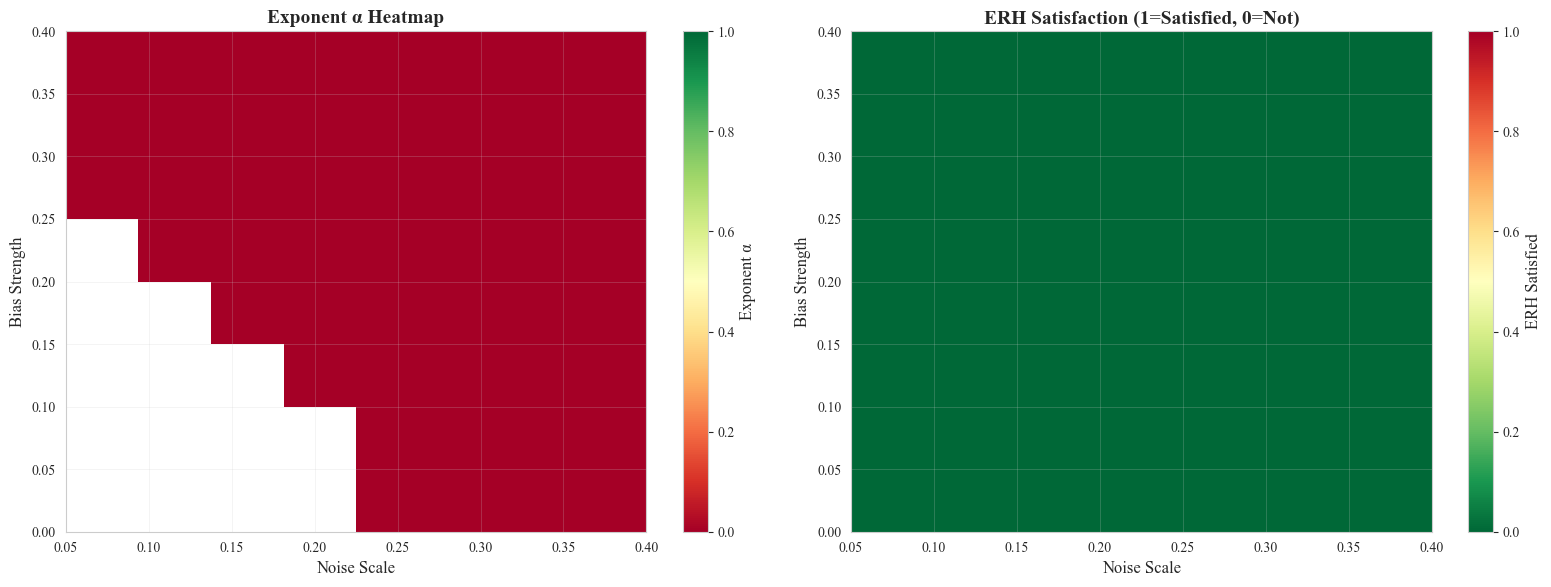


No parameter combinations found that satisfy ERH in this range


In [3]:
# 2D sweep: bias_strength vs noise_scale
print("Running 2D parameter sweep (this may take a moment)...")
bias_range = np.linspace(0, 0.4, 8)
noise_range = np.linspace(0.05, 0.4, 8)
exponent_grid = np.zeros((len(bias_range), len(noise_range)))
erh_grid = np.zeros((len(bias_range), len(noise_range)))

for i, bias in enumerate(bias_range):
    for j, noise in enumerate(noise_range):
        actions = generate_world(num_actions=num_actions, random_seed=42)
        judge = BiasedJudge(bias_strength=bias, noise_scale=noise)
        evaluate_judgement(actions, judge, tau=tau)
        primes = select_ethical_primes(actions)
        
        if len(primes) > 10:
            Pi_x, B_x, E_x, x_vals = compute_Pi_and_error(primes, X_max=X_max)
            analysis = analyze_error_growth(E_x, x_vals)
            exponent_grid[i, j] = analysis['estimated_exponent']
            erh_grid[i, j] = 1 if analysis.get('erh_satisfied', False) else 0
        else:
            exponent_grid[i, j] = np.nan
            erh_grid[i, j] = 0

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Exponent heatmap
ax1 = axes[0]
im1 = ax1.imshow(exponent_grid, extent=[noise_range[0], noise_range[-1], bias_range[0], bias_range[-1]],
                 aspect='auto', origin='lower', cmap='RdYlGn', vmin=0, vmax=1)
ax1.contour(noise_range, bias_range, exponent_grid, levels=[0.5], colors='black', linewidths=2)
ax1.set_xlabel('Noise Scale', fontsize=12)
ax1.set_ylabel('Bias Strength', fontsize=12)
ax1.set_title('Exponent α Heatmap', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=ax1, label='Exponent α')

# ERH satisfaction heatmap
ax2 = axes[1]
im2 = ax2.imshow(erh_grid, extent=[noise_range[0], noise_range[-1], bias_range[0], bias_range[-1]],
                 aspect='auto', origin='lower', cmap='RdYlGn_r', vmin=0, vmax=1)
ax2.set_xlabel('Noise Scale', fontsize=12)
ax2.set_ylabel('Bias Strength', fontsize=12)
ax2.set_title('ERH Satisfaction (1=Satisfied, 0=Not)', fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=ax2, label='ERH Satisfied')

plt.tight_layout()
plt.savefig('../output/figures/04_2d_heatmap.pdf', dpi=300)
plt.show()

# Find parameter combinations that satisfy ERH
satisfied_mask = erh_grid == 1
if np.any(satisfied_mask):
    satisfied_bias = bias_range[np.where(satisfied_mask)[0]]
    satisfied_noise = noise_range[np.where(satisfied_mask)[1]]
    print(f"\nFound {len(satisfied_bias)} parameter combinations that satisfy ERH")
    print("Sample combinations:")
    for i in range(min(5, len(satisfied_bias))):
        print(f"  Bias={satisfied_bias[i]:.3f}, Noise={satisfied_noise[i]:.3f}")
else:
    print("\nNo parameter combinations found that satisfy ERH in this range")


## Parameter Importance Ranking

Compute sensitivity metrics to rank parameters by their impact on ERH satisfaction.


Parameter Sensitivity Ranking:
Bias Strength:  4.8618 (higher = more sensitive)
Noise Scale:   3.7968 (higher = more sensitive)


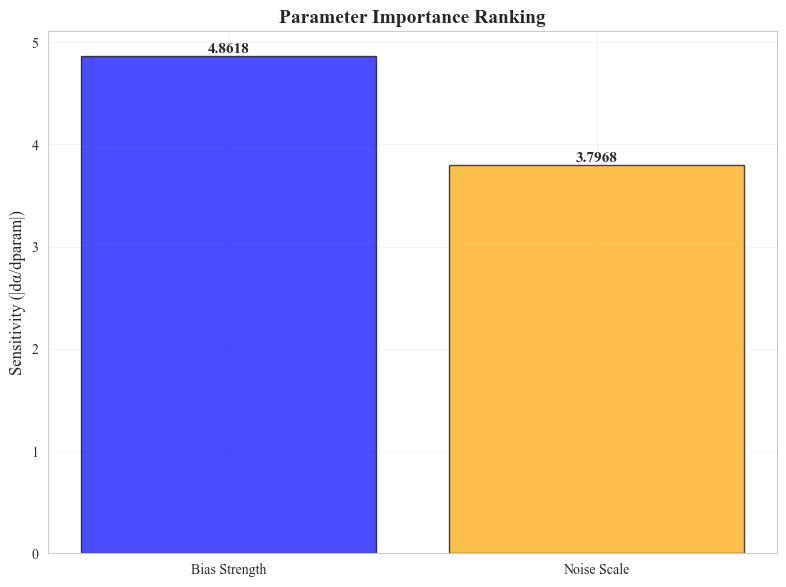

In [4]:
# Compute partial derivatives (sensitivity) for each parameter
def compute_sensitivity(param_values, exponents):
    """Compute sensitivity as rate of change"""
    valid_mask = ~np.isnan(exponents)
    if np.sum(valid_mask) < 2:
        return np.nan
    
    param_clean = np.array(param_values)[valid_mask]
    exp_clean = np.array(exponents)[valid_mask]
    
    # Compute gradient (slope)
    if len(param_clean) > 1:
        sensitivity = np.gradient(exp_clean, param_clean)
        return np.mean(np.abs(sensitivity))
    return np.nan

# Compute sensitivities
bias_sensitivity = compute_sensitivity(bias_strengths, exponents_bias)
noise_sensitivity = compute_sensitivity(noise_scales, exponents_noise)

print("Parameter Sensitivity Ranking:")
print("=" * 60)
print(f"Bias Strength:  {bias_sensitivity:.4f} (higher = more sensitive)")
print(f"Noise Scale:   {noise_sensitivity:.4f} (higher = more sensitive)")

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
params = ['Bias Strength', 'Noise Scale']
sensitivities = [bias_sensitivity, noise_sensitivity]
colors = ['blue', 'orange']

bars = ax.bar(params, sensitivities, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Sensitivity (|dα/dparam|)', fontsize=12)
ax.set_title('Parameter Importance Ranking', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, sens in zip(bars, sensitivities):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{sens:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/figures/04_parameter_importance.pdf', dpi=300)
plt.show()


## Optimization: Find Parameters that Satisfy ERH

Search for parameter combinations that satisfy the Ethical Riemann Hypothesis.


In [5]:
# Objective function: minimize distance from ERH threshold
def objective(params):
    """Minimize |α - 0.5| to find parameters close to ERH threshold"""
    bias, noise = params
    actions = generate_world(num_actions=num_actions, random_seed=42)
    judge = BiasedJudge(bias_strength=max(0, min(0.5, bias)), noise_scale=max(0.05, min(0.5, noise)))
    evaluate_judgement(actions, judge, tau=tau)
    primes = select_ethical_primes(actions)
    
    if len(primes) > 10:
        Pi_x, B_x, E_x, x_vals = compute_Pi_and_error(primes, X_max=X_max)
        analysis = analyze_error_growth(E_x, x_vals)
        alpha = analysis['estimated_exponent']
        # Penalize if alpha > 0.5, reward if alpha <= 0.5
        return abs(alpha - 0.5) if not np.isnan(alpha) else 10.0
    return 10.0

# Optimize
print("Optimizing parameters to satisfy ERH...")
result = minimize(objective, x0=[0.1, 0.1], method='Nelder-Mead', 
                  bounds=[(0, 0.5), (0.05, 0.5)], options={'maxiter': 20})

if result.success:
    opt_bias, opt_noise = result.x
    print(f"\nOptimal parameters found:")
    print(f"  Bias Strength: {opt_bias:.4f}")
    print(f"  Noise Scale: {opt_noise:.4f}")
    print(f"  Objective value: {result.fun:.4f}")
    
    # Verify
    actions_opt = generate_world(num_actions=num_actions, random_seed=42)
    judge_opt = BiasedJudge(bias_strength=opt_bias, noise_scale=opt_noise)
    evaluate_judgement(actions_opt, judge_opt, tau=tau)
    primes_opt = select_ethical_primes(actions_opt)
    
    if len(primes_opt) > 10:
        Pi_x, B_x, E_x, x_vals = compute_Pi_and_error(primes_opt, X_max=X_max)
        analysis_opt = analyze_error_growth(E_x, x_vals)
        print(f"\nVerification:")
        print(f"  Exponent α: {analysis_opt['estimated_exponent']:.4f}")
        print(f"  ERH Satisfied: {analysis_opt.get('erh_satisfied', False)}")
else:
    print("Optimization did not converge. Try different initial values.")


Optimizing parameters to satisfy ERH...

Optimal parameters found:
  Bias Strength: 0.1000
  Noise Scale: 0.1000
  Objective value: 10.0000


## Export Sensitivity Matrix

Save parameter sensitivity results for further analysis.


In [6]:
# Export results
os.makedirs('../output', exist_ok=True)
import pandas as pd

# Create sensitivity matrix
sensitivity_data = {
    'Parameter': ['Bias Strength', 'Noise Scale'],
    'Sensitivity': [bias_sensitivity, noise_sensitivity],
    'Min Exponent': [np.nanmin(exponents_bias), np.nanmin(exponents_noise)],
    'Max Exponent': [np.nanmax(exponents_bias), np.nanmax(exponents_noise)],
    'Mean Exponent': [np.nanmean(exponents_bias), np.nanmean(exponents_noise)]
}

sensitivity_df = pd.DataFrame(sensitivity_data)
sensitivity_df.to_csv('../output/parameter_sensitivity_matrix.csv', index=False)
print("Exported sensitivity matrix to: ../output/parameter_sensitivity_matrix.csv")
print("\nSensitivity Matrix:")
print(sensitivity_df.to_string(index=False))

# Export 2D grid data
grid_data = {
    'bias_strength': np.repeat(bias_range, len(noise_range)),
    'noise_scale': np.tile(noise_range, len(bias_range)),
    'exponent': exponent_grid.flatten(),
    'erh_satisfied': erh_grid.flatten()
}
grid_df = pd.DataFrame(grid_data)
grid_df.to_csv('../output/2d_parameter_grid.csv', index=False)
print("\nExported 2D parameter grid to: ../output/2d_parameter_grid.csv")


Exported sensitivity matrix to: ../output/parameter_sensitivity_matrix.csv

Sensitivity Matrix:
    Parameter  Sensitivity  Min Exponent  Max Exponent  Mean Exponent
Bias Strength     4.861759     -0.961980      0.048654      -0.242898
  Noise Scale     3.796839     -1.072362     -0.213512      -0.455033

Exported 2D parameter grid to: ../output/2d_parameter_grid.csv
